# Key Points of DCGAN
- We prefer strided conv (for Discriminator) rather than     max pooling
- 1 to many mapping occurse in Transpose Convolution
  ie: []1x1 --> []3x3
  
- Medium Link: https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0

# 1. Data Collection- Paintings91

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# # unzip the data
# !unzip drive/My\ Drive/Paintings91

# 2. Dependencies

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import keras
from keras.preprocessing import image
from keras.layers import *
from keras.models import *
from keras.activations import *
from keras.optimizers import *
from keras.applications import ResNet50

# 3. Data Pipeline

In [0]:
num_images = len(os.listdir('Paintings91/Images/'))

In [0]:
img = plt.imread('Paintings91/Images/ALBRECHT_DURER_12.jpg')

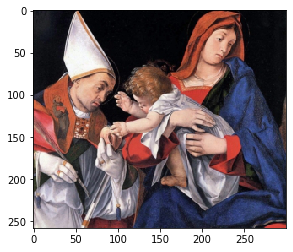

In [7]:
plt.imshow(img)

In [61]:
img.shape

(258, 300, 3)

### read the images

In [0]:
path = 'Paintings91/Images/'

In [0]:
x_train= np.empty((num_images, 256, 256, 3))

In [13]:
i = 0
for each in os.listdir(path):
  x_train[i]=image.img_to_array(image.load_img(path+each, target_size=(256, 256)))
  if i%500==0:
    print('{} images processed'.format(i))
  i+=1
  

0 images processed
500 images processed
1000 images processed
1500 images processed
2000 images processed
2500 images processed
3000 images processed
3500 images processed
4000 images processed


In [15]:
print(x_train.shape)

(4266, 256, 256, 3)


In [0]:
# normalize the images [-1, 1]
x_train = (x_train.astype(dtype=np.float16) - 127.0)/127.0

In [18]:
np.max(x_train)

1.008

# 4. Building Model

#### Model Parameters

In [0]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(x_train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)

NOISE_DIM = 100

adam = Adam(lr=2e-4,beta_1=0.5)

#### Building Generator
- Output of the generator should be shape of image or x_train[0].shape

In [0]:
def create_generator():
  generator = Sequential()
  generator.add(Dense(4*4*128,input_shape=(NOISE_DIM,)))
  generator.add(Reshape((4,4,128)))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization())


  # double the spatial size 8x8x64
  # upsampling with 2d transpose convolution
  generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2, 2), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization())

  # repeat the above to move towards the desired shape now shape will be 16x16x64
  # upsampling with 2d transpose convolution
  generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2, 2), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization())

  # repeat the above to move towards the desired shape now shape will be 32x32x64
  # upsampling with 2d transpose convolution
  generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2, 2), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization())


  # repeat the above to move towards the desired shape now shape will be 64x64x64
  # upsampling with 2d transpose convolution
  generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2, 2), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization())

  # repeat the above to move towards the desired shape now shape will be 128x128x64
  # upsampling with 2d transpose convolution
  generator.add(Conv2DTranspose(64, kernel_size=(5,5), strides=(2, 2), padding='same'))
  generator.add(LeakyReLU(0.2))
  generator.add(BatchNormalization())

  # repeat the above to move towards the desired shape now shape will be 256x256x3
  # upsampling with 2d transpose convolution
  generator.add(Conv2DTranspose(3, kernel_size=(5,5), strides=(2, 2), padding='same', activation='tanh'))
  
  generator.compile(optimizer=adam, loss='binary_crossentropy')
  
  
  return generator


In [0]:
generator = create_generator()

In [111]:
generator.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 2048)              206848    
_________________________________________________________________
reshape_23 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
leaky_re_lu_113 (LeakyReLU)  (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose_60 (Conv2DT (None, 8, 8, 64)          204864    
_________________________________________________________________
leaky_re_lu_114 (LeakyReLU)  (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 8, 8, 64)        

### Build Discriminator

In [0]:
def create_dicriminator():
  
#   model = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet', classes=2)
#   x = GlobalAveragePooling2D()(model.output)
#   x = Dense(units=64, activation='relu')(x)
#   x = Dense(units=16, activation='relu')(x)
#   x = Dense(units=8, activation='relu')(x)
#   output = Dense(units=2, activation='softmax')(x)
#   discriminator = Model(inputs=model.input, outputs=output)
  
#   discriminator.compile(optimizer=adam, loss='binary_crossentropy')



  discriminator = Sequential()
  discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), input_shape=(256, 256, 3), activation=LeakyReLU(0.2),padding='same'))
  
  # new shape 128x128x64
  discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), activation=LeakyReLU(0.2), padding='same'))
  
  # new shape 64x64x64
  discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), activation=LeakyReLU(0.2), padding='same'))

  # new shape 32x32x64
  discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), activation=LeakyReLU(0.2), padding='same'))

  # new shape 16x16x64
  discriminator.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), activation=LeakyReLU(0.2), padding='same'))
  
  # new shape 8x8x64
  discriminator.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2, 2), activation=LeakyReLU(0.2), padding='same'))
  
  
  # new shape 4x4x128
#   discriminator.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2, 2), activation=LeakyReLU(0.2)))

  # flatten the output
  discriminator.add(Flatten())

  # output layer
  discriminator.add(Dense(units=1, activation='sigmoid'))
  
  # compile model
  discriminator.compile(optimizer=adam, loss='binary_crossentropy')
 
  
  return discriminator

In [0]:
discriminator =  create_dicriminator()

In [122]:
discriminator.summary()
generator.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 128, 128, 64)      4864      
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 64, 64, 64)        102464    
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 16, 16, 64)        102464    
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 8, 8, 64)          102464    
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)            

#### Whoa the model has been created

# Model Training

In [130]:
!mkdir images
!mkdir models

mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘models’: File exists


In [0]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

#Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

def save_imgs(epoch,samples=12):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,256,256, 3)
    
    plt.figure(figsize=(12,12))
    for i in range(samples):
        plt.subplot(3,4,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()


In [0]:
NUM_EPOCHS = 200

Epoch 1 D loss: 5.485884 G loss: 19.109605
Epoch 2 D loss: 5.164955 G loss: 34.867408
Epoch 3 D loss: 4.399936 G loss: 31.169625
Epoch 4 D loss: 3.589632 G loss: 4.689844
Epoch 5 D loss: 3.049077 G loss: 1.130637
Epoch 6 D loss: 2.956044 G loss: 0.698742
Epoch 7 D loss: 2.910786 G loss: 0.614223
Epoch 8 D loss: 2.922320 G loss: 0.649501
Epoch 9 D loss: 2.929516 G loss: 0.858244
Epoch 10 D loss: 2.918973 G loss: 0.831581
Epoch 11 D loss: 2.903873 G loss: 0.753302
Epoch 12 D loss: 7.096906 G loss: 47.528851
Epoch 13 D loss: 7.017724 G loss: 53.543806
Epoch 14 D loss: 5.665907 G loss: 42.443759
Epoch 15 D loss: 3.718084 G loss: 5.394567
Epoch 16 D loss: 2.986856 G loss: 0.863389
Epoch 17 D loss: 2.910769 G loss: 0.726814
Epoch 18 D loss: 2.903936 G loss: 0.900849
Epoch 19 D loss: 4.941774 G loss: 26.929038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20 D loss: 6.001742 G loss: 37.931538


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


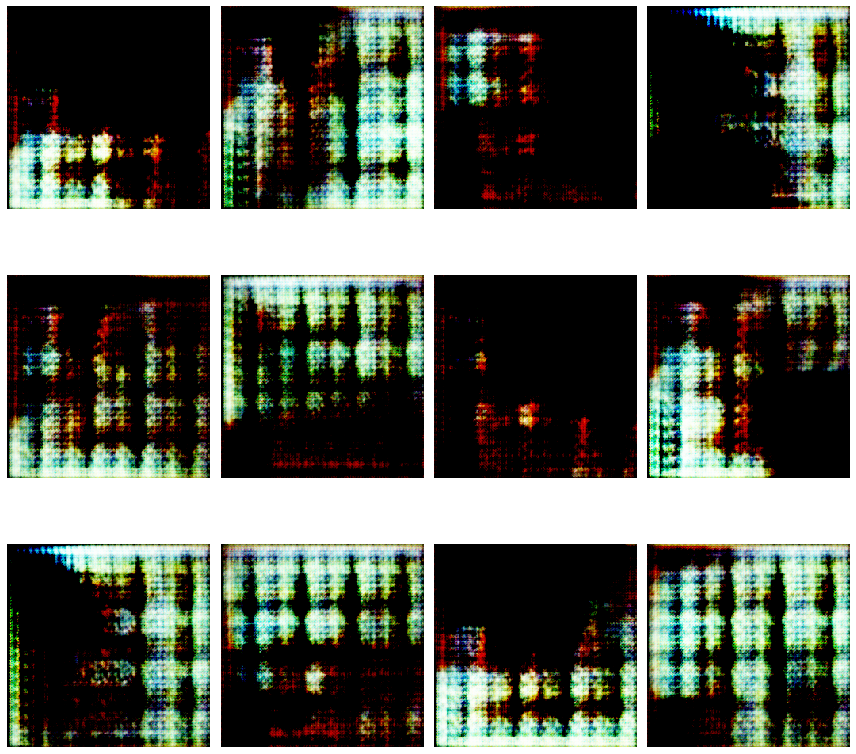

Epoch 21 D loss: 4.994247 G loss: 30.239244
Epoch 22 D loss: 3.744871 G loss: 3.242038
Epoch 23 D loss: 3.215412 G loss: 2.818102
Epoch 24 D loss: 3.086092 G loss: 2.551171
Epoch 25 D loss: 3.164970 G loss: 5.064022
Epoch 26 D loss: 3.153986 G loss: 3.777659
Epoch 27 D loss: 6.879614 G loss: 64.077321
Epoch 28 D loss: 5.686777 G loss: 55.608917
Epoch 29 D loss: 5.061953 G loss: 37.082037
Epoch 30 D loss: 3.086081 G loss: 2.625054
Epoch 31 D loss: 2.994838 G loss: 2.513847
Epoch 32 D loss: 2.991737 G loss: 3.265330
Epoch 33 D loss: 3.098162 G loss: 4.270577
Epoch 34 D loss: 7.000966 G loss: 52.929392
Epoch 35 D loss: 3.584515 G loss: 3.744204
Epoch 36 D loss: 3.181674 G loss: 2.407052
Epoch 37 D loss: 3.048302 G loss: 2.522633
Epoch 38 D loss: 6.756145 G loss: 24.313435
Epoch 39 D loss: 4.704024 G loss: 75.165071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40 D loss: 4.953890 G loss: 40.012218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


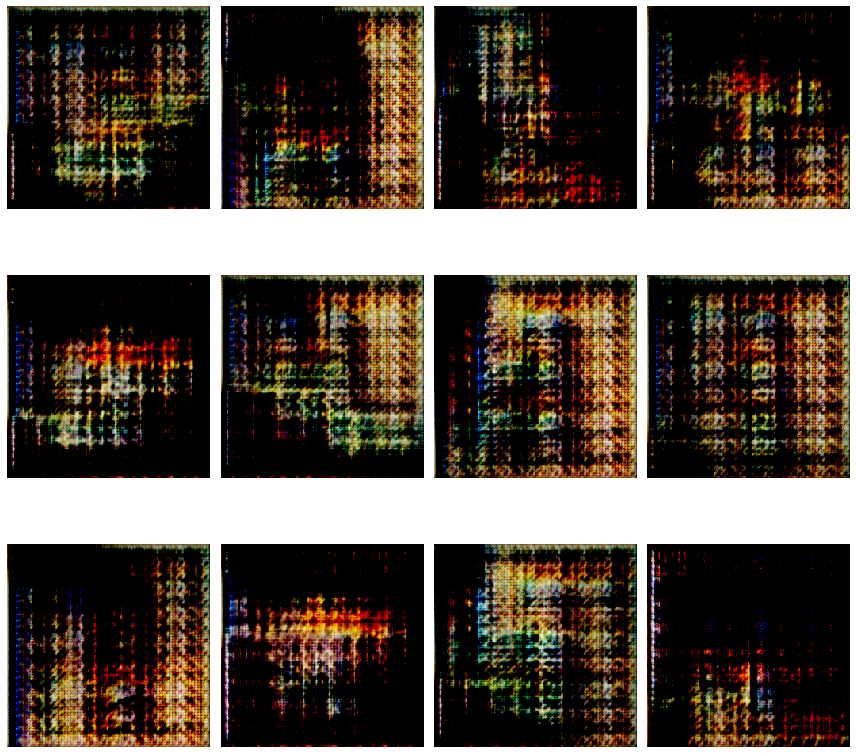

Epoch 41 D loss: 3.071822 G loss: 1.178683
Epoch 42 D loss: 2.901607 G loss: 0.505746
Epoch 43 D loss: 2.874706 G loss: 0.483608
Epoch 44 D loss: 2.877871 G loss: 0.651100
Epoch 45 D loss: 2.940888 G loss: 1.912213
Epoch 46 D loss: 5.963930 G loss: 70.269986
Epoch 47 D loss: 5.480363 G loss: 62.432859
Epoch 48 D loss: 4.557955 G loss: 15.871529
Epoch 49 D loss: 3.602863 G loss: 7.305664
Epoch 50 D loss: 3.250735 G loss: 5.106312
Epoch 51 D loss: 5.377196 G loss: 16.448331
Epoch 52 D loss: 3.503509 G loss: 5.064478
Epoch 53 D loss: 2.930273 G loss: 1.216263
Epoch 54 D loss: 2.869148 G loss: 1.067591
Epoch 55 D loss: 2.853251 G loss: 1.126253
Epoch 56 D loss: 2.893782 G loss: 1.450088
Epoch 57 D loss: 6.820248 G loss: 9.246609
Epoch 58 D loss: 3.388959 G loss: 3.164293
Epoch 59 D loss: 3.301486 G loss: 8.495512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60 D loss: 3.426852 G loss: 8.163733


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


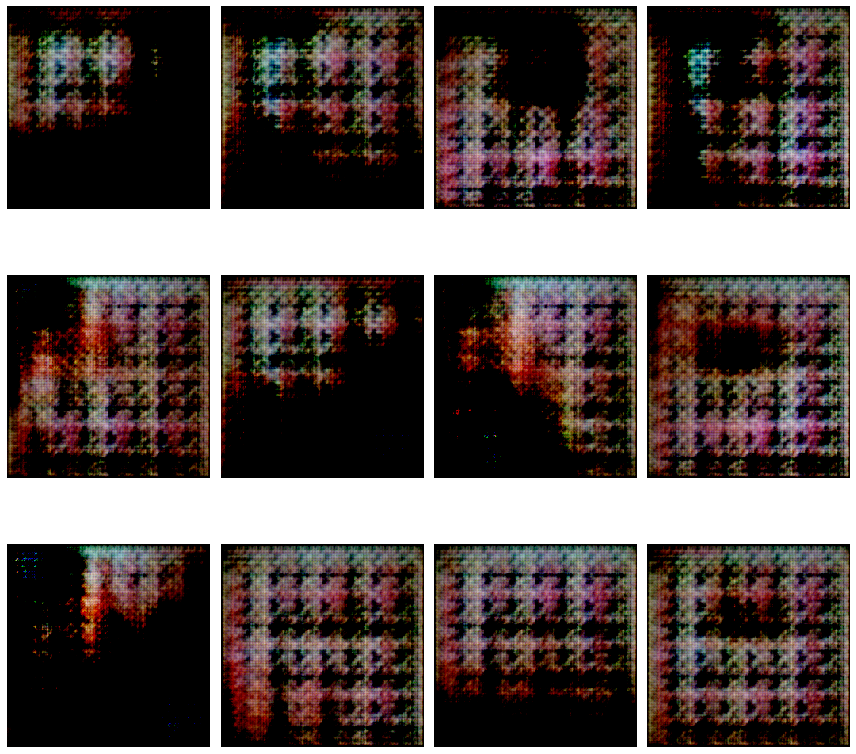

Epoch 61 D loss: 3.407911 G loss: 9.510846
Epoch 62 D loss: 2.959502 G loss: 3.686686
Epoch 63 D loss: 2.924668 G loss: 1.820875
Epoch 64 D loss: 2.892308 G loss: 1.186143
Epoch 65 D loss: 7.506417 G loss: 25.526497
Epoch 66 D loss: 6.413717 G loss: 64.421660
Epoch 67 D loss: 6.635068 G loss: 41.972091
Epoch 68 D loss: 4.633563 G loss: 17.159943
Epoch 69 D loss: 3.551988 G loss: 4.141213
Epoch 70 D loss: 3.230838 G loss: 2.837296
Epoch 71 D loss: 3.204528 G loss: 2.021322
Epoch 72 D loss: 3.244490 G loss: 3.269841
Epoch 73 D loss: 3.433888 G loss: 6.738682
Epoch 74 D loss: 4.231857 G loss: 43.618048
Epoch 75 D loss: 3.049748 G loss: 3.137275
Epoch 76 D loss: 2.893359 G loss: 1.455402
Epoch 77 D loss: 2.861193 G loss: 1.007188
Epoch 78 D loss: 2.846371 G loss: 0.831824
Epoch 79 D loss: 2.858238 G loss: 0.837498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80 D loss: 8.250679 G loss: 37.174094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


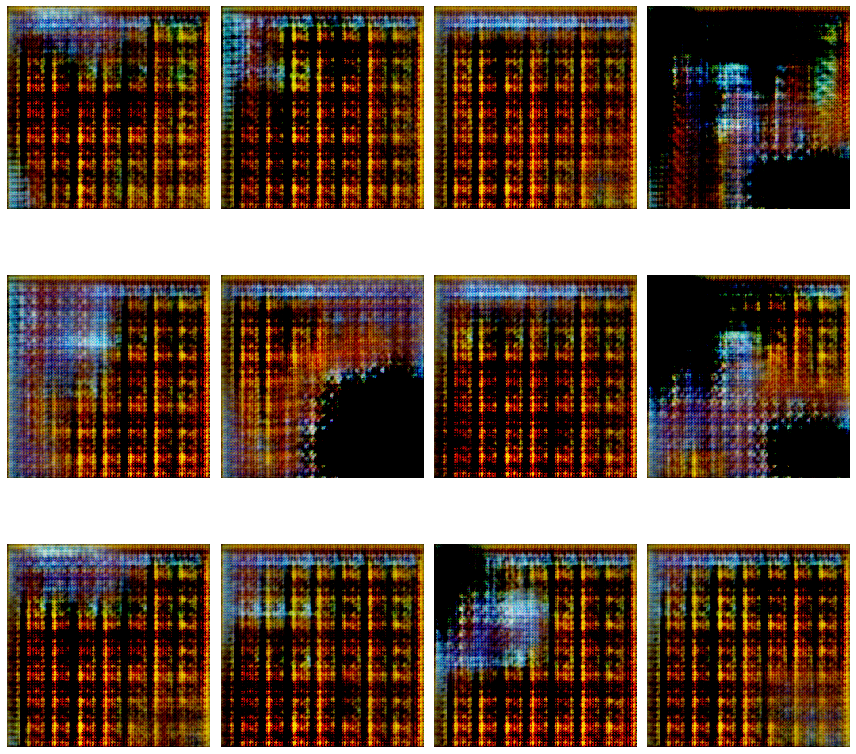

Epoch 81 D loss: 3.472448 G loss: 4.880639
Epoch 82 D loss: 5.717742 G loss: 31.981946
Epoch 83 D loss: 3.247672 G loss: 3.010457
Epoch 84 D loss: 3.018013 G loss: 2.148017
Epoch 85 D loss: 3.019091 G loss: 2.019664
Epoch 86 D loss: 3.069289 G loss: 2.994536
Epoch 87 D loss: 5.731504 G loss: 25.303535
Epoch 88 D loss: 3.015499 G loss: 0.940230
Epoch 89 D loss: 2.914756 G loss: 0.678406
Epoch 90 D loss: 2.884868 G loss: 0.814490
Epoch 91 D loss: 2.888694 G loss: 0.897766
Epoch 92 D loss: 2.910819 G loss: 1.443872
Epoch 93 D loss: 4.700974 G loss: 59.989550
Epoch 94 D loss: 4.744099 G loss: 26.259723
Epoch 95 D loss: 3.461102 G loss: 9.854845
Epoch 96 D loss: 5.752274 G loss: 16.160853
Epoch 97 D loss: 3.551111 G loss: 5.303260
Epoch 98 D loss: 3.239052 G loss: 3.759153
Epoch 99 D loss: 4.106814 G loss: 12.083566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100 D loss: 8.168303 G loss: 75.514487


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


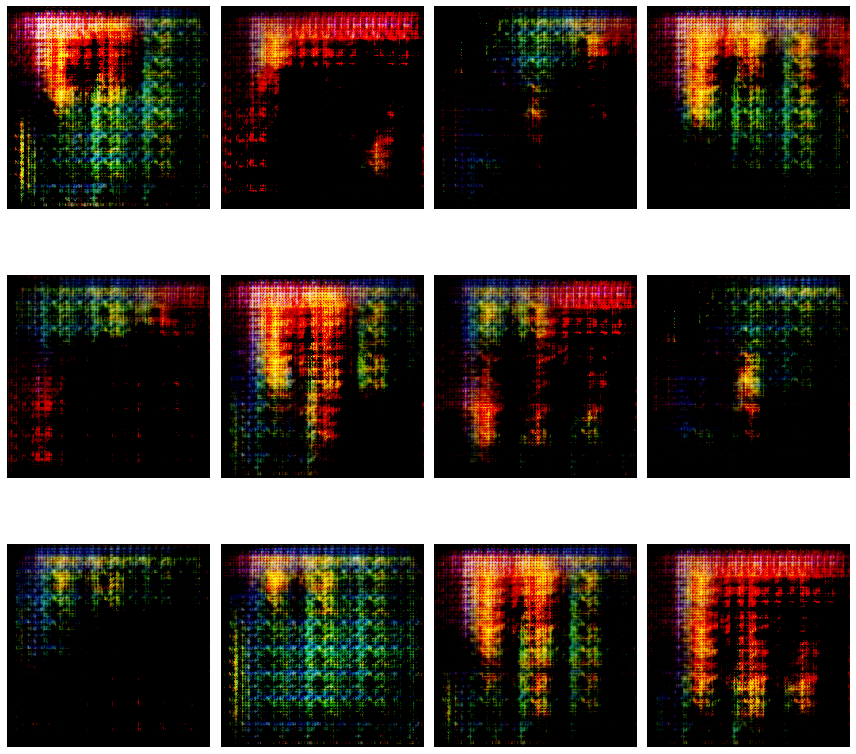

Epoch 101 D loss: 5.349236 G loss: 49.463518
Epoch 102 D loss: 3.688481 G loss: 13.216404
Epoch 103 D loss: 3.074158 G loss: 2.268850
Epoch 104 D loss: 3.004427 G loss: 3.590423
Epoch 105 D loss: 4.736584 G loss: 55.087125
Epoch 106 D loss: 4.832434 G loss: 56.324449
Epoch 107 D loss: 3.211500 G loss: 5.385343
Epoch 108 D loss: 2.982674 G loss: 2.000048
Epoch 109 D loss: 2.917750 G loss: 1.302932
Epoch 110 D loss: 2.943372 G loss: 1.872128
Epoch 111 D loss: 2.981922 G loss: 2.097476
Epoch 112 D loss: 4.982064 G loss: 19.090641
Epoch 113 D loss: 3.623589 G loss: 11.294059
Epoch 114 D loss: 3.267144 G loss: 5.119859
Epoch 115 D loss: 3.073743 G loss: 2.269636
Epoch 116 D loss: 3.051076 G loss: 5.794849
Epoch 117 D loss: 7.673534 G loss: 55.368104
Epoch 118 D loss: 5.435588 G loss: 42.947639
Epoch 119 D loss: 4.834832 G loss: 20.976304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 120 D loss: 3.599962 G loss: 7.666177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


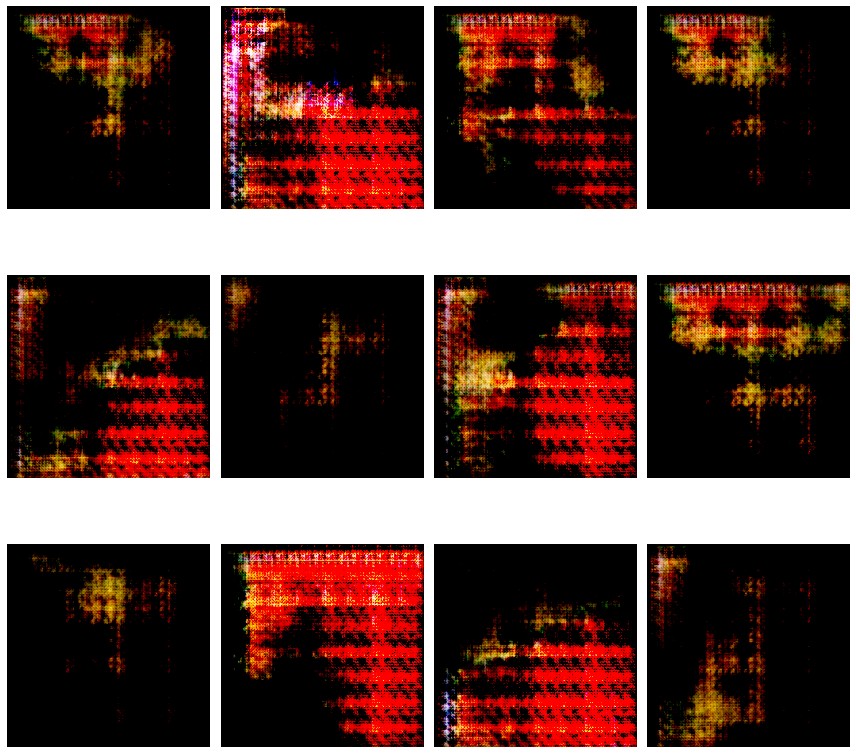

Epoch 121 D loss: 3.066327 G loss: 2.199289
Epoch 122 D loss: 2.947460 G loss: 1.419173
Epoch 123 D loss: 2.899646 G loss: 0.997703
Epoch 124 D loss: 2.862792 G loss: 0.782746
Epoch 125 D loss: 2.871394 G loss: 0.798319
Epoch 126 D loss: 2.872505 G loss: 1.012534
Epoch 127 D loss: 8.262834 G loss: 59.704288
Epoch 128 D loss: 4.921130 G loss: 30.809020
Epoch 129 D loss: 3.330790 G loss: 3.417358
Epoch 130 D loss: 4.813629 G loss: 17.397514
Epoch 131 D loss: 3.918768 G loss: 20.008805
Epoch 132 D loss: 3.534888 G loss: 25.342800
Epoch 133 D loss: 5.005438 G loss: 24.750620
Epoch 134 D loss: 2.991987 G loss: 2.322941
Epoch 135 D loss: 2.851823 G loss: 0.885541
Epoch 136 D loss: 2.845504 G loss: 0.778033
Epoch 137 D loss: 2.829602 G loss: 0.677536
Epoch 138 D loss: 2.820556 G loss: 0.624821
Epoch 139 D loss: 2.820198 G loss: 0.710242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 140 D loss: 2.829903 G loss: 0.793890


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


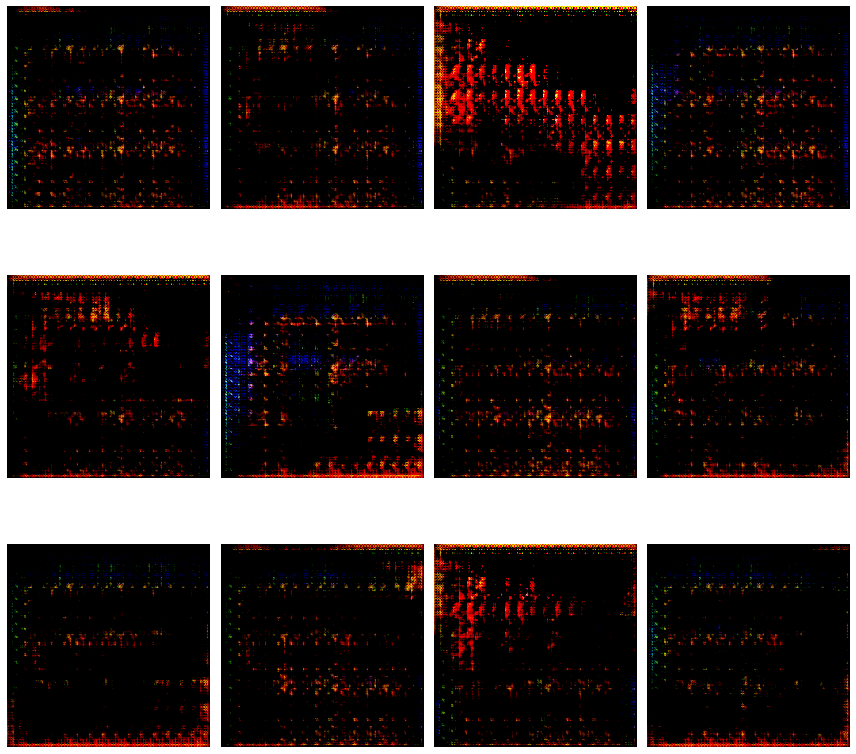

Epoch 141 D loss: 2.836620 G loss: 0.956046
Epoch 142 D loss: 2.810981 G loss: 0.681817
Epoch 143 D loss: 9.576135 G loss: 43.517145
Epoch 144 D loss: 5.793487 G loss: 68.124738
Epoch 145 D loss: 4.506985 G loss: 32.514944
Epoch 146 D loss: 3.977795 G loss: 7.028554
Epoch 147 D loss: 2.960873 G loss: 1.080614
Epoch 148 D loss: 2.895895 G loss: 0.791639
Epoch 149 D loss: 2.866999 G loss: 0.717015
Epoch 150 D loss: 2.848792 G loss: 0.654193
Epoch 151 D loss: 2.869342 G loss: 0.860919
Epoch 152 D loss: 4.685601 G loss: 40.936750
Epoch 153 D loss: 3.412690 G loss: 17.387433
Epoch 154 D loss: 3.020422 G loss: 5.045452
Epoch 155 D loss: 5.724754 G loss: 50.677452
Epoch 156 D loss: 5.165857 G loss: 32.319742
Epoch 157 D loss: 3.865062 G loss: 11.822968
Epoch 158 D loss: 4.837489 G loss: 36.008955
Epoch 159 D loss: 3.235866 G loss: 16.905312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 160 D loss: 3.326921 G loss: 11.474847


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


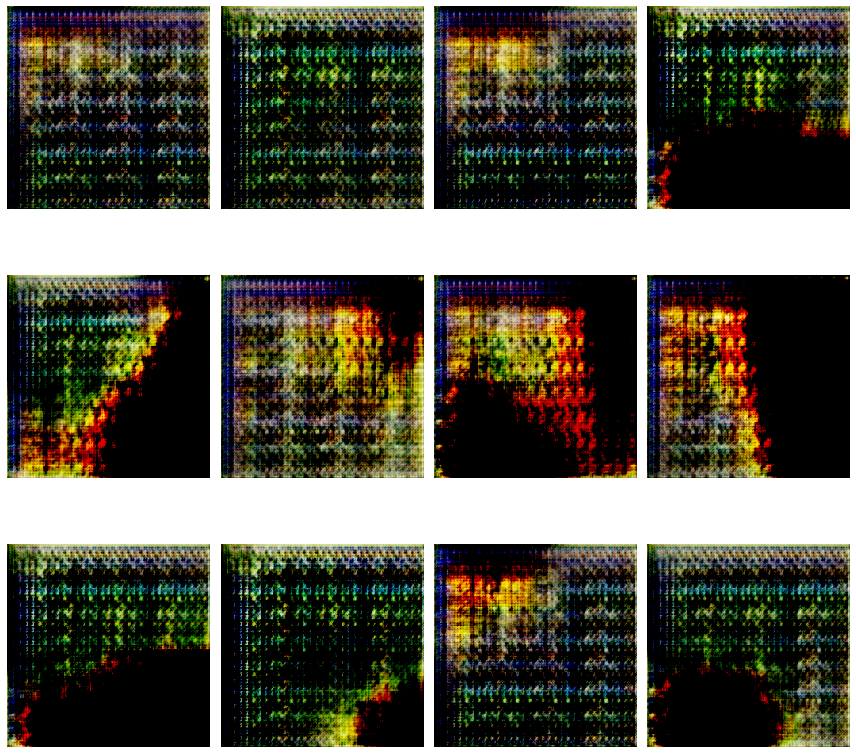

Epoch 161 D loss: 2.992543 G loss: 2.164656
Epoch 162 D loss: 2.977906 G loss: 1.363075
Epoch 163 D loss: 2.875121 G loss: 1.128300
Epoch 164 D loss: 2.847912 G loss: 0.959751
Epoch 165 D loss: 2.869369 G loss: 0.963558
Epoch 166 D loss: 5.499053 G loss: 30.477252
Epoch 167 D loss: 7.162358 G loss: 55.629415
Epoch 168 D loss: 4.113111 G loss: 27.361302
Epoch 169 D loss: 3.673139 G loss: 7.758674
Epoch 170 D loss: 2.917068 G loss: 1.205432
Epoch 171 D loss: 2.928238 G loss: 1.785243
Epoch 172 D loss: 2.940205 G loss: 2.474361
Epoch 173 D loss: 2.901980 G loss: 2.355117
Epoch 174 D loss: 2.966964 G loss: 6.498303
Epoch 175 D loss: 3.105164 G loss: 4.970840
Epoch 176 D loss: 2.859607 G loss: 0.818100
Epoch 177 D loss: 2.856289 G loss: 1.238356
Epoch 178 D loss: 4.943772 G loss: 70.864266
Epoch 179 D loss: 3.265304 G loss: 13.086870


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 180 D loss: 2.925727 G loss: 2.350589


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


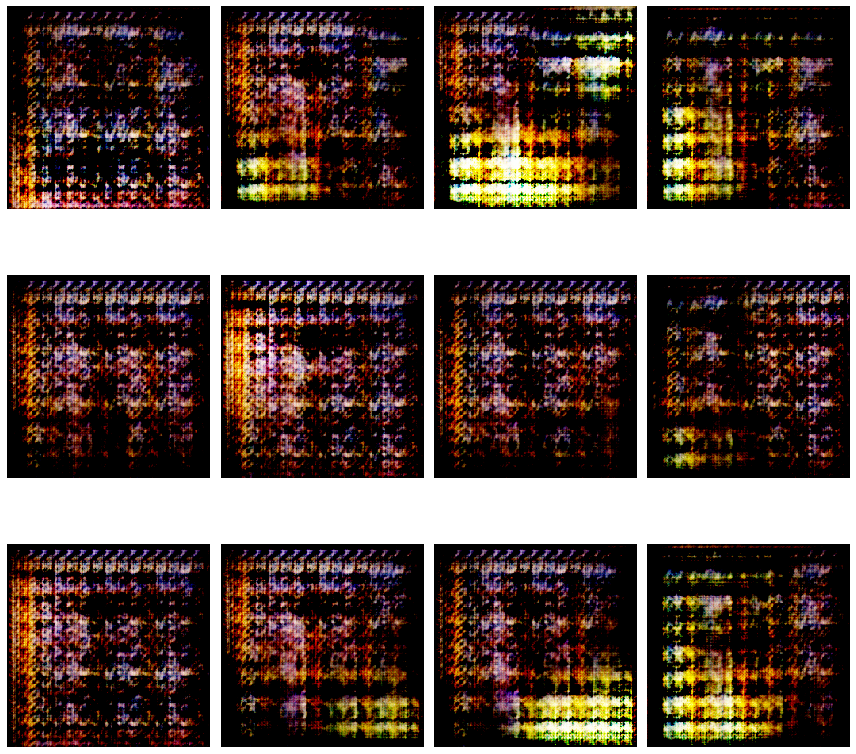

Epoch 181 D loss: 2.869652 G loss: 1.396684
Epoch 182 D loss: 2.850942 G loss: 1.229910
Epoch 183 D loss: 2.857577 G loss: 1.819673
Epoch 184 D loss: 4.770310 G loss: 50.993621
Epoch 185 D loss: 3.079490 G loss: 5.714564
Epoch 186 D loss: 2.940459 G loss: 3.996950
Epoch 187 D loss: 2.931354 G loss: 5.170056
Epoch 188 D loss: 2.970195 G loss: 8.729129
Epoch 189 D loss: 3.194604 G loss: 15.044679
Epoch 190 D loss: 2.936755 G loss: 3.603181
Epoch 191 D loss: 3.086192 G loss: 5.055395
Epoch 192 D loss: 3.037239 G loss: 2.872207
Epoch 193 D loss: 2.834915 G loss: 1.064221
Epoch 194 D loss: 2.832303 G loss: 0.955399
Epoch 195 D loss: 2.830973 G loss: 1.063945
Epoch 196 D loss: 2.876141 G loss: 1.972711
Epoch 197 D loss: 3.267301 G loss: 9.588576
Epoch 198 D loss: 2.874589 G loss: 1.843639
Epoch 199 D loss: 2.826031 G loss: 1.099827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 200 D loss: 5.586863 G loss: 35.440786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


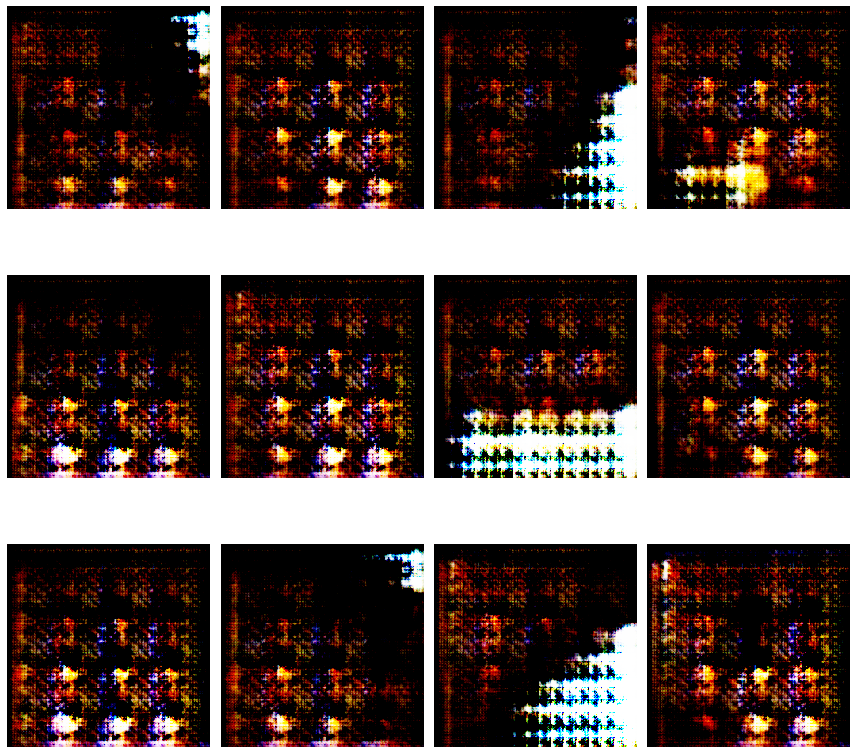

In [140]:
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,x_train.shape[0],HALF_BATCH_SIZE)
        real_imgs = x_train[idx]
        
        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        
        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1))
        
        # train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y) #updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y) 
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        
        epoch_d_loss += d_loss
        
        
        #Train Generator (Complete Model Generator + Frozen Discriminator)
        
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        real_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,real_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d D loss: %f G loss: %f" % ((epoch + 1), epoch_d_loss, epoch_g_loss))

    if (epoch+1)%20==0:
        generator.save('models/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)

In [128]:
256*256*3

196608

In [129]:
19660800/196608

100.0